### Importing Dependencies

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline

### Data Preprocessing

In [2]:
df = pd.read_csv(r'C:\Users\Admin\Desktop\Project\dataset\dengue08.csv')
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,cases
0,2008-01-01,0
1,2008-02-01,0
2,2008-03-01,0
3,2008-04-01,0
4,2008-05-01,0


In [3]:
df.set_index('date', inplace=True)

#### Data Transformation for LSTM

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Normalizing the dataset
scaler = MinMaxScaler()
df['scaled_cases'] = scaler.fit_transform(df['cases'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 12

X_train, y_train = create_dataset(df[['scaled_cases']], df['scaled_cases'], TIME_STEPS)

#### LSTM

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Building the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Additional LSTM Layer
model.add(LSTM(50, return_sequences=False))  # return_sequences is False for the last LSTM layer

# Output layer
model.add(Dense(1))

# Compiling the model with an Adam optimizer and a learning rate of 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, epochs=100,batch_size=16, verbose=0)


# Making predictions on the training set
train_preds = model.predict(X_train)
train_preds = scaler.inverse_transform(train_preds)
actual_train_values = scaler.inverse_transform(y_train.reshape(-1, 1))

# Forecasting for 2024
forecasts = []
last_data = df[['scaled_cases']].values[-TIME_STEPS:]

for _ in range(12):  # forecasting for each month of 2024
    pred = model.predict(last_data.reshape(1, TIME_STEPS, 1))
    forecasts.append(scaler.inverse_transform(pred)[0, 0])
    last_data = np.append(last_data[1:], pred)

#### LSTM forecast visualization

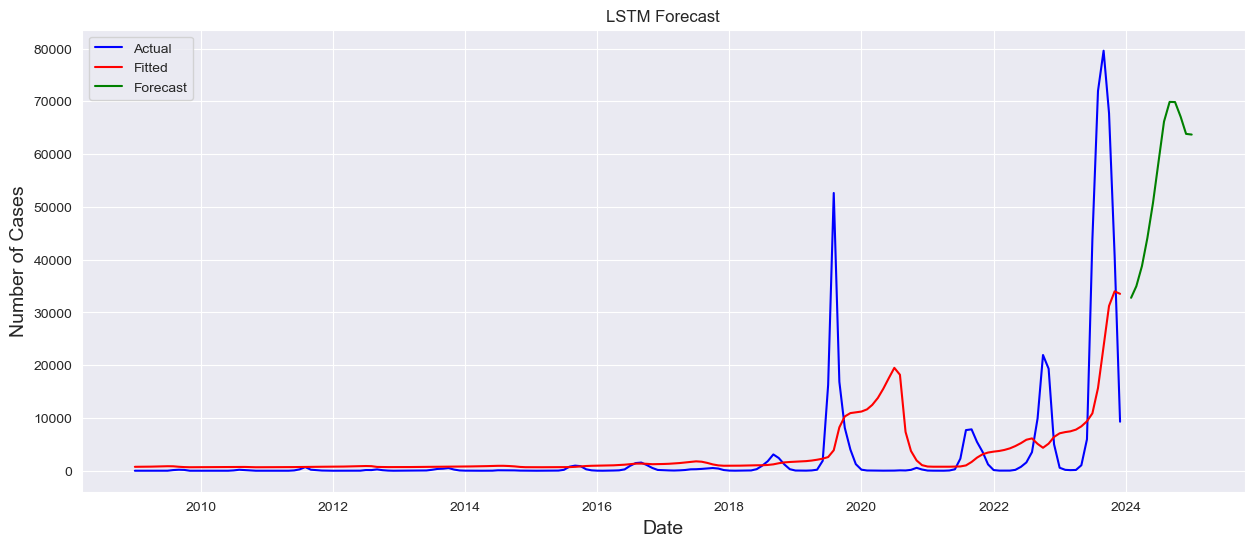

In [11]:
# Visualizing the forecasts for 2024 along with actual and fitted data
sns.set_style("darkgrid")
plt.figure(figsize=(15, 6))
plt.plot(df.index[TIME_STEPS:], actual_train_values, label='Actual', color='blue')
plt.plot(df.index[TIME_STEPS:], train_preds, label='Fitted', color='red')
plt.plot(pd.date_range(start='2024-01-01', periods=12, freq='M'), forecasts, label='Forecast', color='green')
plt.title('LSTM Forecast')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Number of Cases", fontsize=14)
plt.legend(loc='upper left')

plt.savefig("010.LSTM_forecast.png", bbox_inches='tight')
plt.show()

In [7]:
print("Forecasted Dengue Cases for 2024:")
print(forecasts)

Forecasted Dengue Cases for 2024:
[32773.49, 34969.438, 38784.977, 44096.5, 50744.875, 58371.62, 66168.36, 69896.18, 69866.805, 67083.72, 63837.055, 63709.5]


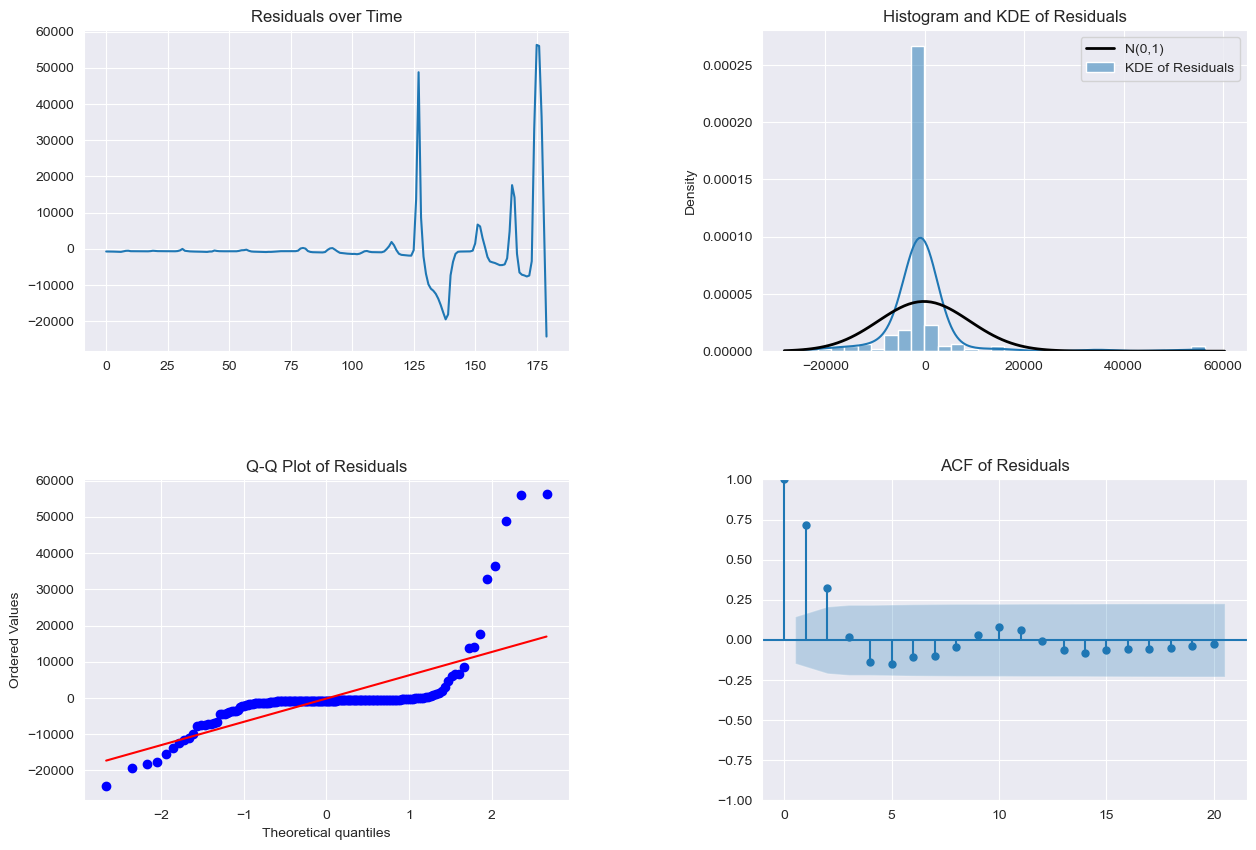

In [8]:
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

# Calculate residuals
residuals = actual_train_values.flatten() - train_preds.flatten()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Residuals over time
axs[0, 0].plot(residuals)
axs[0, 0].set_title('Residuals over Time')

# Histogram and KDE
sns.histplot(residuals, kde=True, stat='density', bins=30, ax=axs[0, 1], label='KDE of Residuals')
xmin, xmax = axs[0, 1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
axs[0, 1].plot(x, p, 'k', linewidth=2, label='N(0,1)')
axs[0, 1].set_title('Histogram and KDE of Residuals')
axs[0, 1].legend()  # Displaying the legend

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot of Residuals')

# ACF plot
plot_acf(residuals, ax=axs[1, 1], lags=20)
axs[1, 1].set_title('ACF of Residuals')

plt.show()

In [9]:
#Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(actual_train_values, train_preds))
print(f'RMSE: {rmse}')

# Calculating MAE
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(actual_train_values, train_preds)
print(f"MAE: {mae_train}")

RMSE: 9190.47427350407
MAE: 3701.169133504232
